In [10]:
import os
import numpy as np
from matplotlib import pylab as plt

import pandas as pd
import math
import random
from functools import reduce
from sklearn.metrics import roc_auc_score

from scipy.stats import wilcoxon

In [11]:
def build_training_and_test_set(has_substructure_path):
    substructure = np.loadtxt(has_substructure_path, np.int)
    all_ones = np.where(substructure == 1)
    all_zeros = np.where(substructure == 0)

    number_of_training_set = int(len(all_ones[0]) * 0.7)
    
    training_random_ones = random.sample(list(all_ones[0]), number_of_training_set)
    training_random_zeros = random.sample(list(all_zeros[0]), number_of_training_set)

    test_random_ones = [ones for ones in all_ones[0] if ones not in training_random_ones]
    test_random_zeros = [zeros for zeros in all_zeros[0] if zeros not in training_random_zeros]
    test_random_zeros = random.sample(test_random_zeros, len(test_random_ones))
    
    return training_random_ones, training_random_zeros, test_random_ones, test_random_zeros
    
def get_list_of_ids(dataset):
    return ["GNPS_ALL_" + str(index+1) for index in dataset]

Building training and test dataset

In [12]:
def load_training_spec(spec_path, training_set):
    file_list = os.listdir(spec_path)
    
    filtered_file_list = [file for file in file_list if file[:-13] in training_set]
    filtered_name_list = [filename[:-13] for filename in filtered_file_list]

    intensities = pd.DataFrame(0.0, index = filtered_name_list, columns=range(1000), dtype=float)

    for file in filtered_file_list:
        filepath = os.path.join(spec_path, file)
        mol_name = file[:-13]
        with open(filepath, 'r') as f:
            for index, line in enumerate(f):
                mass, intensity = line.split(" ")
                if not math.isnan(float(intensity)):
                    intensities.at[mol_name, int(mass)-1] = float(intensity)
            
    return intensities

def load_test_spec(spec_path, test_set):
    file_list = os.listdir(spec_path)
    
    filtered_file_list = [file for file in file_list if file[:-13] in test_set]
    filtered_name_list = [filename[:-13] for filename in filtered_file_list]

    test_intensities = pd.DataFrame(0.0, index = filtered_name_list, columns=range(1000), dtype=float)

    for file in filtered_file_list:
        filepath = os.path.join(spec_path, file)
        mol_name = file[:-13]
        with open(filepath, 'r') as f:
            for index, line in enumerate(f):
                mass, intensity = line.split(" ")
                if not math.isnan(float(intensity)):
                    test_intensities.at[mol_name, int(mass)-1] = float(intensity)
           
    return test_intensities

In [13]:
def load_has_substructure(content, intensities):
    has_substructure_truth_values = []
    for index in intensities.index:
        has_substructure_truth_values.append(int(content[int(index.split('_')[2]) - 1][:-1]))
        
    return has_substructure_truth_values

Make a simple keras model to classify this data

In [14]:
from keras.layers import Input, Dense
from keras.models import Model,Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD

def just_fragments_model(input_to_network):
    class_model = Sequential()
    class_model.add(Dense(500, input_dim=input_to_network.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(200,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(100,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(50,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(1,kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return class_model

def just_shifts_model(input_to_network):
    class_model = Sequential()
    class_model.add(Dense(500, input_dim=input_to_network.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(200,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(100,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(50,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(1,kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return class_model

def fragments_shifts_model(input_to_network):
    class_model = Sequential()
    class_model.add(Dense(1000, input_dim=input_to_network.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(500,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(200,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(100,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(50,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(1,kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return class_model

Using TensorFlow backend.


Second model for comparison

In [15]:
def calc_peak_differences(spec):
    non_zero_peaks = list(np.where(spec>0)[0])
    peak_differences = [(abs(i-j), (spec[i]+spec[j]/2.0)) for i in non_zero_peaks for j in non_zero_peaks if i != j and j > i]
    
    return peak_differences

In [16]:
def load_shift_bins(intensities):
    shift_bins = pd.DataFrame(0.0, index = intensities.index, columns=range(intensities.shape[1]), dtype=float)
    for index, spec in enumerate(intensities.values):
        peak_differences = calc_peak_differences(spec)
        mol_name = intensities.index[index]
        for shift, average_intensity in peak_differences:
            shift_bins.at[mol_name, shift-1] += average_intensity
        shift_bins.loc[mol_name].div(np.amax(intensities.loc[mol_name].values)).mul(999)
    return shift_bins

In [17]:
def initialise_training_test_set(has_substruct_path):
    training_random_ones, training_random_zeros, test_random_ones, test_random_zeros = build_training_and_test_set(has_substruct_path)
    training_random_ones_id = get_list_of_ids(training_random_ones)
    training_random_zeros_id = get_list_of_ids(training_random_zeros)
    training_set = training_random_ones_id + training_random_zeros_id

    test_random_ones_id = get_list_of_ids(test_random_ones)
    test_random_zeros_id = get_list_of_ids(test_random_zeros)
    test_set = test_random_ones_id + test_random_zeros_id
    return training_set, test_set

def train_fragments_diff_splits(path, name, has_substruct_dataset, training_set, test_set, splits=10):
    filtered_dataset_dir = "G:\\Dev\\Data\\MSMS-NIST\\Python Filtered"
    epochs = 200
    extra_epochs = 100
    path = path + name
    truth_values = []
    test_truth_values = []

    with open(has_substruct_dataset, 'r') as f:
        content = f.readlines()

    with open(path, 'w') as f:
        for i in range(splits):
            intensities = load_training_spec(filtered_dataset_dir, training_set)
            intensities = intensities.reindex(index=intensities.index.to_series().str.rsplit('_').str[-1].astype(int).sort_values().index)
           
            test_intensities = load_test_spec(filtered_dataset_dir, test_set)
            test_intensities = test_intensities.reindex(index=test_intensities.index.to_series().str.rsplit('_').str[-1].astype(int).sort_values().index)

            truth_values = load_has_substructure(content, intensities)
            test_truth_values = load_has_substructure(content, test_intensities)

            X = intensities.values
            N,M = X.shape
            print(X.shape)
            shuffle_order = np.random.permutation(N)
            labels = truth_values
            labels = np.array(labels)[:,None]
            test_labels = test_truth_values
            test_labels = np.array(test_labels)[:,None]

            mod = just_fragments_model(X)
            mod.fit(X[shuffle_order,:],labels[shuffle_order],epochs=extra_epochs,validation_split=0.2,verbose=0)

            x_test_spec = test_intensities.values
            predicted = mod.predict(x_test_spec)

            auc = roc_auc_score(test_labels, predicted)
            f.write(str(auc) + "\n")
            
def train_shifts_diff_splits(path, name, has_substruct_dataset, training_set, test_set, splits=10):
    filtered_dataset_dir = "G:\\Dev\\Data\\MSMS-NIST\\Python Filtered"
    epochs = 200
    extra_epochs = 100
    path = path + name
    truth_values = []
    test_truth_values = []

    with open(has_substruct_dataset, 'r') as f:
        content = f.readlines()

    with open(path, 'w') as f:
        for i in range(splits):
            intensities = load_training_spec(filtered_dataset_dir, training_set)
            intensities = intensities.reindex(index=intensities.index.to_series().str.rsplit('_').str[-1].astype(int).sort_values().index)
           
            test_intensities = load_test_spec(filtered_dataset_dir, test_set)
            test_intensities = test_intensities.reindex(index=test_intensities.index.to_series().str.rsplit('_').str[-1].astype(int).sort_values().index)

            truth_values = load_has_substructure(content, intensities)
            test_truth_values = load_has_substructure(content, test_intensities)

            X = intensities.values
            N,M = X.shape
            shuffle_order = np.random.permutation(N)
            labels = truth_values
            labels = np.array(labels)[:,None]
            test_labels = test_truth_values
            test_labels = np.array(test_labels)[:,None]

            shift_bins = load_shift_bins(intensities).values
            print(shift_bins.shape)

            mod = just_shifts_model(shift_bins)
            mod.fit(shift_bins[shuffle_order,:],labels[shuffle_order],epochs=extra_epochs,validation_split=0.2,verbose=0)

            test_shift_bins = load_shift_bins(test_intensities).values
            print(test_shift_bins.shape)

            predicted = mod.predict(test_shift_bins)

            auc = roc_auc_score(test_labels, predicted)
            f.write(str(auc) + "\n")

def train_fragments_and_shifts_diff_splits(path, name, has_substruct_dataset, training_set, test_set, splits=10):
    filtered_dataset_dir = "G:\\Dev\\Data\\MSMS-NIST\\Python Filtered"
    epochs = 200
    extra_epochs = 100
    path = path + name
    truth_values = []
    test_truth_values = []

    with open(has_substruct_dataset, 'r') as f:
        content = f.readlines()

    with open(path, 'w') as f:
        for i in range(splits):
            intensities = load_training_spec(filtered_dataset_dir, training_set)
            intensities = intensities.reindex(index=intensities.index.to_series().str.rsplit('_').str[-1].astype(int).sort_values().index)
           
            test_intensities = load_test_spec(filtered_dataset_dir, test_set)
            test_intensities = test_intensities.reindex(index=test_intensities.index.to_series().str.rsplit('_').str[-1].astype(int).sort_values().index)

            truth_values = load_has_substructure(content, intensities)
            test_truth_values = load_has_substructure(content, test_intensities)

            X = intensities.values
            N,M = X.shape
            shuffle_order = np.random.permutation(N)
            labels = truth_values
            labels = np.array(labels)[:,None]
            test_labels = test_truth_values
            test_labels = np.array(test_labels)[:,None]

            shift_bins = load_shift_bins(intensities)
            x_fragments_shifts = pd.concat([intensities, shift_bins], axis=1)
            x_fragments_shifts.columns = range(2000)
            print(x_fragments_shifts.shape)

            mod = fragments_shifts_model(x_fragments_shifts.values)
            mod.fit(x_fragments_shifts.values[shuffle_order,:],labels[shuffle_order],epochs=extra_epochs,validation_split=0.2,verbose=0)

            test_shift_bins = load_shift_bins(test_intensities)            
            x_fragments_shifts_test = pd.concat([test_intensities, test_shift_bins], axis=1)
            x_fragments_shifts_test.columns = range(2000)
            print(x_fragments_shifts_test.shape)

            predicted = mod.predict(x_fragments_shifts_test.values)

            auc = roc_auc_score(test_labels, predicted)
            f.write(str(auc) + "\n")

In [18]:
amino_acid_path = "G:\\Dev\\Data\\Fragment Masses.txt"
amino_acids_with_shifts = []

with open(amino_acid_path, 'r') as f:
    for line in f:
        amino_acid, shift = line.split(", ")
        amino_acids_with_shifts.append((amino_acid, int(float(shift[:-1]))))

print(amino_acids_with_shifts)

[('Alanine', 71), ('Arginine', 156), ('Asparagine', 114), ('Aspartic Acid', 115), ('Cysteine', 103), ('Glutamic Acid', 129), ('Glutamine', 128), ('Glycine', 57), ('Histidine', 137), ('Isoleucine', 113), ('Leucine', 113), ('Lysine', 128), ('Methionine', 131), ('Phenylalanine', 147), ('Proline', 97), ('Serine', 87), ('Threonine', 101), ('Tryptophan', 186), ('Tyrosine', 163), ('Valine', 99)]


In [11]:
missing_amino_acid = "Glutamine"
path = "G:\\Dev\\Data\\Shift vs No Shifts Experiments\\"

for amino_acid, shift in amino_acids_with_shifts:
    if amino_acid != missing_amino_acid and amino_acid not in processed_amino_acid:
        dataset = "G:\\Dev\\Data\\NIST Amino Acids\\NIST {} Has Substructure.txt".format(amino_acid)
        training_set, test_set = initialise_training_test_set(dataset)
        train_fragments_diff_splits(path, "Fragments {} AUC.txt".format(amino_acid), dataset, training_set, test_set)
        train_shifts_diff_splits(path, "Shifts {} AUC.txt".format(amino_acid), dataset, training_set, test_set)
        train_fragments_and_shifts_diff_splits(path, "Fragments and Shifts {} AUC.txt".format(amino_acid), dataset, training_set, test_set)

(716, 1000)
(716, 1000)
(716, 1000)
(716, 1000)
(716, 1000)
(716, 1000)
(716, 1000)
(716, 1000)
(716, 1000)
(716, 1000)
(716, 1000)
(308, 1000)
(716, 1000)
(308, 1000)
(716, 1000)
(308, 1000)
(716, 1000)
(308, 1000)
(716, 1000)
(308, 1000)
(716, 1000)
(308, 1000)
(716, 1000)
(308, 1000)
(716, 1000)
(308, 1000)
(716, 1000)
(308, 1000)
(716, 1000)
(308, 1000)
(716, 2000)
(308, 2000)
(716, 2000)
(308, 2000)
(716, 2000)
(308, 2000)
(716, 2000)
(308, 2000)
(716, 2000)
(308, 2000)
(716, 2000)
(308, 2000)
(716, 2000)
(308, 2000)
(716, 2000)
(308, 2000)
(716, 2000)
(308, 2000)
(716, 2000)
(308, 2000)


In [22]:
path = "G:\\Dev\\Data\\Shift vs No Shifts Experiments\\"
amino_acid = "Serine"
dataset = "G:\\Dev\\Data\\NIST Amino Acids\\NIST {} Has Substructure.txt".format(amino_acid)
training_set, test_set = initialise_training_test_set(dataset)
train_fragments_and_shifts_diff_splits(path, "Fragments and Shifts {} AUC.txt".format(amino_acid), dataset, training_set, test_set)

(610, 2000)
(264, 2000)
(610, 2000)
(264, 2000)
(610, 2000)
(264, 2000)
(610, 2000)
(264, 2000)
(610, 2000)
(264, 2000)
(610, 2000)
(264, 2000)
(610, 2000)
(264, 2000)
(610, 2000)
(264, 2000)
(610, 2000)
(264, 2000)
(610, 2000)
(264, 2000)


Statistics=0.000, p=0.00013
Statistics=0.000, p=0.00013
Statistics=0.000, p=0.00013
Different distribution (reject H0)


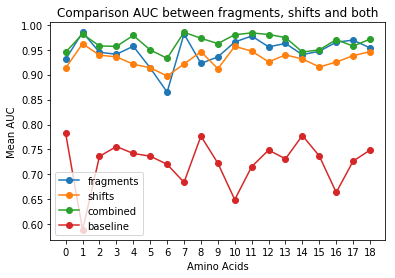

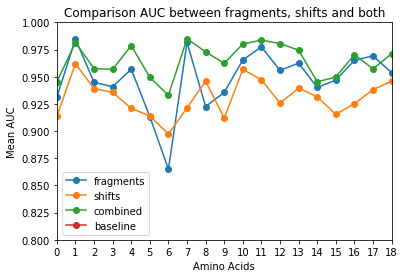

In [30]:
nist_baseline_auc_path = "G:\\Dev\\Data\\NIST Amino Acids\\NIST Baseline AUC.txt"
result_path = "G:\\Dev\\Data\\Shift vs No Shifts Experiments\\" # each amino acid has 10 aucs

amino_acid_names = [amino_acid[0] for amino_acid in amino_acids_with_shifts]
baseline_aucs = []
mean_fragment_aucs = []
mean_shift_aucs = []
mean_both_aucs = []

with open(nist_baseline_auc_path, 'r') as f:
    for line in f:
        amino_acid, baseline_auc = line.split(",")
        baseline_aucs.append(float(baseline_auc[:-1]))

missing_amino_acid = "Glutamine"
for amino_acid in amino_acid_names:
    if amino_acid != missing_amino_acid:
        amino_acid_fragments_auc_path = os.path.join(result_path, "Fragments {} AUC.txt".format(amino_acid))
        amino_acid_shifts_auc_path = os.path.join(result_path, "Shifts {} AUC.txt".format(amino_acid))
        amino_acid_both_auc_path = os.path.join(result_path, "Fragments and Shifts {} AUC.txt".format(amino_acid))
        
        with open(amino_acid_fragments_auc_path, 'r') as f:
            numbers = (float(line[:-1]) for line in f)
            mean_fragment_auc = reduce(np.add, numbers)/10
            mean_fragment_aucs.append(mean_fragment_auc)
            
        with open(amino_acid_shifts_auc_path, 'r') as f:
            numbers = (float(line[:-1]) for line in f)
            mean_shift_auc = reduce(np.add, numbers)/10
            mean_shift_aucs.append(mean_shift_auc)
            
        with open(amino_acid_both_auc_path, 'r') as f:
            numbers = (float(line[:-1]) for line in f)
            mean_both_auc = reduce(np.add, numbers)/10
            mean_both_aucs.append(mean_both_auc)

stat, p = wilcoxon(mean_fragment_aucs, baseline_aucs)
print('Statistics=%.3f, p=%.5f' % (stat, p))

stat, p = wilcoxon(mean_shift_aucs, baseline_aucs)
print('Statistics=%.3f, p=%.5f' % (stat, p))

stat, p = wilcoxon(mean_both_aucs, baseline_aucs)
print('Statistics=%.3f, p=%.5f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')
    
plt.plot(range(len(amino_acid_names)-1), mean_fragment_aucs, '-o', label="fragments")
plt.plot(range(len(amino_acid_names)-1), mean_shift_aucs, '-o', label="shifts")
plt.plot(range(len(amino_acid_names)-1), mean_both_aucs, '-o', label="combined")
plt.plot(range(len(amino_acid_names)-1), baseline_aucs, '-o', label="baseline")
plt.legend()
plt.title("Comparison AUC between fragments, shifts and both")
plt.xlabel("Amino Acids")
plt.xticks(range(len(amino_acid_names)-1))
plt.ylabel("Mean AUC")
plt.show()

plt.plot(range(len(amino_acid_names)-1), mean_fragment_aucs, '-o', label="fragments")
plt.plot(range(len(amino_acid_names)-1), mean_shift_aucs, '-o', label="shifts")
plt.plot(range(len(amino_acid_names)-1), mean_both_aucs, '-o', label="combined")
plt.plot(range(len(amino_acid_names)-1), baseline_aucs, '-o', label="baseline")
plt.legend()
plt.title("Comparison AUC between fragments, shifts and both")
plt.xlabel("Amino Acids")
plt.xticks(range(len(amino_acid_names)-1))
plt.ylabel("Mean AUC")
plt.ylim(0.8, 1)
plt.xlim(0,18)
plt.show()